## Phase 3 — Exploratory Data Analysis (EDA)

Purpose: turn the cleaned & engineered dataset into concise, business-grade insights. Produce repeatable outputs (tables, figures, a short narrative) that answer the stakeholder questions we agreed on (stocking, discontinuation, quality, discount effectiveness).

OVERALL GAMEPLAN (order of execution)

1. Brand Performance Analysis (ranking + validation)

2. Category Insights (aggregations by category_group)

3. Price-Tier & Discount Analysis (price_tier × discount_tier × sentiment)

4. Discount Effectiveness (do deeper discounts improve sentiment/ratings?)

5. Ultra-Discount Deep Dive (inspect ultra_discount cases individually)

6. Sentiment vs Rating Alignment (text vs numeric consistency check)

7. Final packaging: visuals, tables, and executive summary

In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
df_3 = pd.read_csv("/workspaces/Amazon-Sales-data-analysis/notebooks/cleaned_data_2.csv") 
df_3.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,...,discount_percentage_num,discount_ratio,price_difference,ultra_discount,brands,price_tier,discount_tier,pos_word,neg_word,customer_sentiment
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,399.0,1099.0,64%,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...",...,64,0.363057,700.0,False,Wayona,Mid,High,True,False,satisfied
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,199.0,349.0,43%,4.0,43994.0,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...",...,43,0.570201,150.0,False,Ambrane,Low,Mid,True,True,Mixed
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,199.0,1899.0,90%,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...",...,90,0.104792,1700.0,False,Sounce,Mid,High,True,False,satisfied
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,329.0,699.0,53%,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...",...,53,0.470672,370.0,False,boAt,Low,Mid,True,True,Mixed
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,154.0,399.0,61%,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...",...,61,0.385965,245.0,False,Portronics,Low,High,True,True,Mixed


In [3]:
# Most products can be derived through the product_id, but this isnt a worthwhile metric.
# Its little and not normalized across the dataset, therefore, i dont plan on using it!

df_3["product_id"].value_counts()

product_id
B08HDJ86NZ    3
B07JW9H4J1    3
B07XLCFSSN    3
B08CF3D7QR    3
B083342NKJ    3
             ..
B07WFPMGQQ    1
B09LHYZ3GJ    1
B0BD3T6Z1D    1
B07WHSJXLF    1
B09QS9X16F    1
Name: count, Length: 1351, dtype: int64

### 1. BRAND PERFORMANCE   

**Goal: surface brands to promote, partner with, or monitor.**

What to compute (brand-level):
 
- n_reviews_brand = total reviews across brand (sum of rating_count or count of review rows).

- avg_rating_brand = mean rating across all brand reviews.

- rating_index = Balancing avg_rating_brand with volume of ratings by using a log transform.

- percent_satisfied_brand = total satisfied reviews / total reviews for brand.

- percent_dissatisfied_brand = total dissatisfied reviews / total reviews for brand.

- satisfaction_index 


**How to rank / filters:**

Ignore brands with very low sample (set a threshold, e.g., n_reviews_brand >= 10).

**Create lists:**

- Top brands: high avg_rating_brand, high percent_satisfied_brand, healthy n_reviews_brand.

- Top trusted brands : high rating_index = mean_rating * np.log1p(total_rating_count)  

- At-risk brands: high discounts + low satisfaction or low avg_rating.

**Validation check**

- Confirm brand extraction correctness (manual sample of 20 names to catch false positives like "The", "New", etc.).

**Suggested visuals & deliverables:**

- Bar: Top 10 brands by avg_rating_brand (filename: reports/brands_top10_rating.png)

- Scatter: avg_rating_brand vs n_reviews_brand (bubble=size=revenue_proxy) (reports/brands_rating_vs_volume.png)

- CSV: reports/brands_summary.csv

Narration excerpt:
“Brand X leads in satisfaction with Y% satisfied and strong volume; Brand Z requires attention — high discounting but low satisfaction suggesting quality or listing issues.

In [4]:
# total number of times each brands was mentioned 
df_3["brands"].value_counts() 

brands
boAt            67
Samsung         36
AmazonBasics    33
Portronics      31
Ambrane         29
                ..
KONVIO           1
Raffles          1
KNYUC            1
INKULTURE        1
Macmillan        1
Name: count, Length: 437, dtype: int64

In [4]:
# Grouping of each respective brands in respect to its total amount of reviews 
brands_rev = df_3.groupby("brands", as_index=False).sum().sort_values("rating_count", ascending=False) 
n_reviews_brand = brands_rev[["brands", "rating_count"]].reset_index(drop=True)

#List of top 10 brands with the highest reviews across the dataframe  
n_reviews_brand.head(10)   

,brands,rating_count
0,boAt,4416568.0
1,Redmi,1878482.0
2,AmazonBasics,1808818.0
3,SanDisk,1426074.0
4,Amazon,1213138.0
5,TP-Link,1027849.0
6,Samsung,901882.0
7,JBL,891075.0
8,MI,774818.0
9,Noise,621421.0


<Axes: ylabel='brands'>

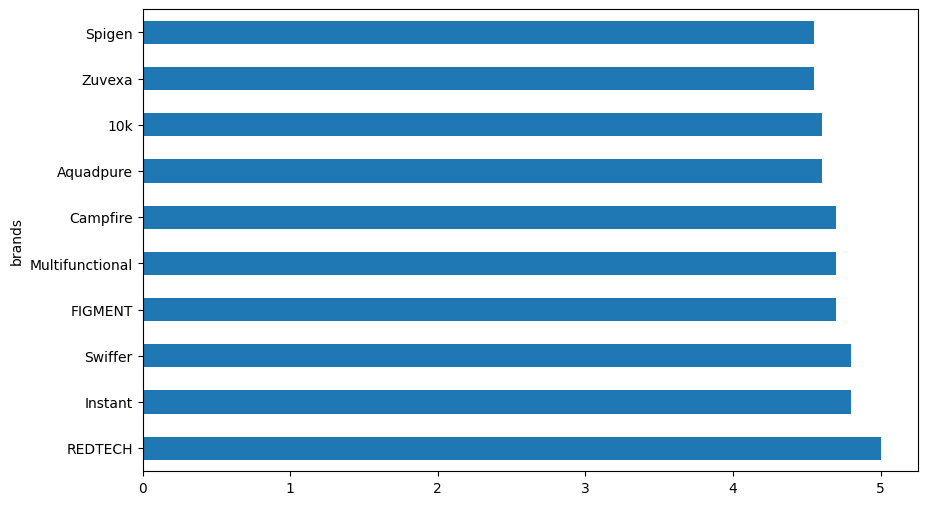

In [ ]:
# Averages of the total ratings present within each brands    
brands_mean = (df_3
               .groupby("brands").agg(mean_rating = ("rating" , "mean"),total_rating_count = ("rating_count", "sum"))
               .query("total_rating_count >= 100")
)
avg_rating_brand = brands_mean.sort_values("mean_rating", ascending=False).reset_index()  

# Most reviewed and well rated brands   
Top_brands = avg_rating_brand.head(10) 

Top_brands.plot(
    kind="barh", x="brands", y="mean_rating", figsize=(10, 6), legend=False
)
plt.ylabel("Average ratings")


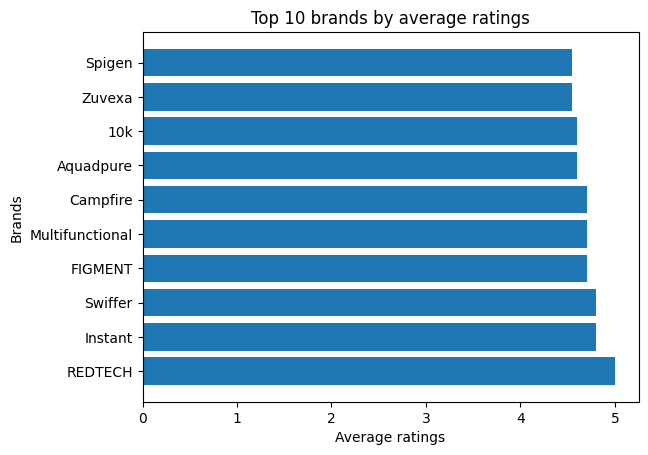

In [20]:
plt.barh(top_brands["brands"], top_brands["mean_rating"])
plt.xlabel("Average ratings")
plt.ylabel("Brands")
plt.title("Top 10 brands by average ratings")


plt.show()

In [8]:
# least mean rated brands and lowest performer
avg_rating_brand.tail(10)

,brands,mean_rating,total_rating_count
387,IONIX,3.4,1465.0
388,SKYWALL,3.4,902.0
389,akiara,3.3,4732.0
390,HUMBLE,3.3,2804.0
391,PRO365,3.3,8427.0
392,4,3.2,113.0
393,Tokdis,3.0,681.0
394,Nirdambhay,3.0,617.0
395,7SEVEN,3.0,103.0
396,MR.,2.8,109.0


In [22]:
# What it does: Balances mean rating with scale of reviews using a log transform.
brands = df_3.groupby("brands").agg(
    mean_rating=("rating", "mean"),
    total_rating_count=("rating_count", "sum")
).reset_index()

# Result bias: Larger categories with tons of ratings dominate (Electronics, Computers),
# but smaller ones with very few ratings can’t shoot up unfairly.
brands["rating_index"] = (brands["mean_rating"] * np.log1p(brands["total_rating_count"]))

brand_rating_index = brands.sort_values("rating_index", ascending=False).reset_index(drop=True).head(10)

 

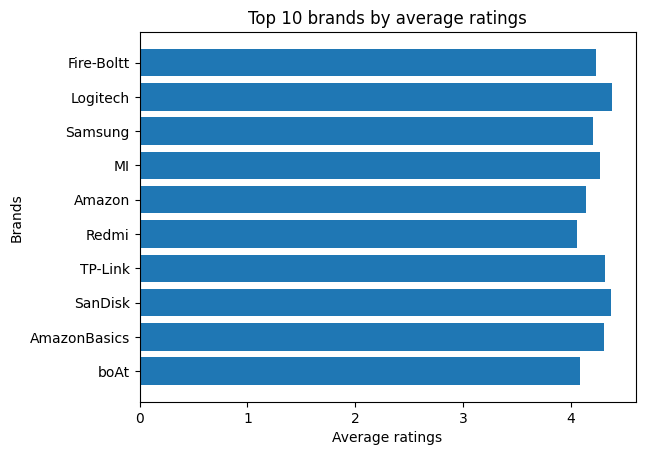

In [23]:
plt.barh(brand_rating_index["brands"], brand_rating_index["mean_rating"])
plt.xlabel("Average ratings")
plt.ylabel("Brands")
plt.title("Top 10 brands by average ratings")


plt.show()

In [9]:
# Mapping sentiments to numerical representations
mapping = {"satisfied": 1.0, "Mixed": 0, "dissatisfied": -1.0}
df_3["sentiment_value"] = df_3["customer_sentiment"].map(mapping) 

In [10]:
brand_sentiment = (df_3.groupby("brands")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                       total_sentiment_score =("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
satisfied_percent = brand_sentiment["total_satisfied"] / brand_sentiment["total_sentiment_score"] * 100
                                                                     
# Final Satisfaction Scoring metric for brands    
brand_sentiment["satisfaction_index"] = satisfied_percent * np.log1p(brand_sentiment["total_sentiment_score"])

# Top Brands with the most satisfied customer
Top_satisfied_brands = brand_sentiment.sort_values("satisfaction_index", ascending=False).reset_index()

Top_satisfied_brands.head(10)

,brands,total_satisfied,total_sentiment_score,satisfaction_index
0,AmazonBasics,25,33,267.148525
1,pTron,13,13,263.905733
2,Duracell,15,20,228.339183
3,Noise,17,24,228.003704
4,Wayona,17,24,228.003704
5,Portronics,20,31,223.595865
6,STRIFF,9,11,203.310544
7,Classmate,9,11,203.310544
8,Bajaj,15,24,201.179739
9,AGARO,10,14,193.432157


In [11]:
brand_sentiment = (df_3.groupby("brands")
                  .agg(total_dissatisfied=("sentiment_value", lambda x: (x == -1).sum()),
                      total_sentiment_score=("sentiment_value", "count")) 
                  .query("total_sentiment_score >= 10")      
)           
# Final dissatisfaction metric for brands        
dissatisfied_percent = brand_sentiment["total_dissatisfied"] / brand_sentiment["total_sentiment_score"] * 100
                                                                    
brand_sentiment["dissatisfaction_index"] = dissatisfied_percent * np.log1p(brand_sentiment["total_sentiment_score"])

# Top dissatisfied brands
Top_dissatisfied_brands = brand_sentiment.sort_values("dissatisfaction_index", ascending=False).reset_index()

Top_dissatisfied_brands.head(10)

,brands,total_dissatisfied,total_sentiment_score,dissatisfaction_index
0,7SEVEN®,2,11,45.180121
1,Samsung,3,36,30.090983
2,Pigeon,1,11,22.590060
3,STRIFF,1,11,22.590060
4,Logitech,1,15,18.483925
5,Zebronics,1,16,17.707583
6,Ambrane,1,29,11.728267
7,AGARO,0,14,0.000000
8,Amazon,0,25,0.000000
9,AmazonBasics,0,33,0.000000


### 2. CATEGORY INSIGHTS 
***Compute per category_group:*** 
- n_reviews_category = total ratings across category (sum of rating_count or count of review rows).

- avg_rating_category = mean rating across all category reviews.

- rating_index

- percent_satisfied_category = total satisfied reviews / total reviews for category.

- percent_dissatisfied_category = total dissatisfied reviews / total reviews for category

- Satisfaction_index = (positives − negatives) ÷ total reviews.


***Deliverables:***

- CSV: reports/category_summary.csv

- Heatmap: satisfaction_index vs price_tier

- Bar: Top 10 categories by satisfaction_index

Narration line:
“Electronics and Storage Devices lead in both review volume and satisfaction; Mobile Accessories lag behind with heavy discounting but low sentiment.”

In [13]:
df_3["category"].unique()

array(['Computers&Accessories', 'Electronics', 'MusicalInstruments',
       'OfficeProducts', 'Home&Kitchen', 'HomeImprovement', 'Toys&Games',
       'Car&Motorbike', 'Health&PersonalCare'], dtype=object)

In [12]:
# Total number of reviews across each categories
n_reviews_category = (df_3.groupby("category")
                     .agg(Total_rating_count = ("rating_count", sum))        
                     .sort_values("Total_rating_count", ascending = False)
                     .reset_index() 
)

n_reviews_category


/tmp/ipykernel_47629/2245536684.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(Total_rating_count = ("rating_count", sum))


,category,Total_rating_count
0,Electronics,15778848.0
1,Computers&Accessories,7739047.0
2,Home&Kitchen,2991069.0
3,OfficeProducts,149675.0
4,MusicalInstruments,88882.0
5,Toys&Games,15867.0
6,HomeImprovement,8566.0
7,Health&PersonalCare,3663.0
8,Car&Motorbike,1118.0


In [13]:
# Mean ratings across each categories
# What it does: Just takes the arithmetic mean of ratings per category.
avg_rating_category = (df_3.groupby("category")
                     .agg(Average_rating = ("rating", "mean"))        
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

# "Result bias: Categories with small review counts can float to the top if their handful of reviews happen to be good."
avg_rating_category


,category,Average_rating
0,OfficeProducts,4.309677
1,Toys&Games,4.300000
2,HomeImprovement,4.250000
3,Computers&Accessories,4.154967
4,Electronics,4.081749
5,Home&Kitchen,4.042857
6,Health&PersonalCare,4.000000
7,MusicalInstruments,3.900000
8,Car&Motorbike,3.800000


In [14]:
# What it does: Balances mean rating with scale of reviews using a log transform.
category = df_3.groupby("category").agg(mean_rating=("rating", "mean"),total_rating_count=("rating_count", "sum")).reset_index()

# Result bias: Larger categories with tons of ratings dominate (Electronics, Computers),
# but smaller ones with very few ratings can’t shoot up unfairly.
category["rating_index"] = (category["mean_rating"] * np.log1p(category["total_rating_count"]))

avg_category_ratings = category.sort_values("rating_index", ascending=False).reset_index(drop=True)

avg_category_ratings.head(10)


,category,mean_rating,total_rating_count,rating_index
0,Electronics,4.081749,15778848.0,67.651647
1,Computers&Accessories,4.154967,7739047.0,65.905209
2,Home&Kitchen,4.042857,2991069.0,60.283616
3,OfficeProducts,4.309677,149675.0,51.355100
4,MusicalInstruments,3.900000,88882.0,44.440797
5,Toys&Games,4.300000,15867.0,41.589857
6,HomeImprovement,4.250000,8566.0,38.486610
7,Health&PersonalCare,4.000000,3663.0,32.825243
8,Car&Motorbike,3.800000,1118.0,26.676725


In [15]:
category_sentiment = (df_3.groupby("category")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                       total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
percent_satisfied_category = (category_sentiment["total_satisfied"] / category_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each categories   
category_sentiment["satisfaction_index"] = percent_satisfied_category * np.log1p(category_sentiment["total_sentiment_score"])

# Top categories with the most satisfied customer
top_satisfied_category = category_sentiment.sort_values("satisfaction_index", ascending=False).reset_index()

top_satisfied_category

,category,total_satisfied,total_sentiment_score,satisfaction_index
0,Computers&Accessories,291,448,396.683853
1,Home&Kitchen,258,437,359.087524
2,Electronics,226,521,271.445849
3,OfficeProducts,22,30,251.825728


In [16]:
category_sentiment = (df_3.groupby("category")
                  .agg(total_dissatisfied=("sentiment_value", lambda x: (x == -1).sum()),
                       total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of dissatisfied customer in a variable        
percent_dissatisfied_category = (category_sentiment["total_dissatisfied"] / category_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final scoring metric of dissatisfied customer in respect to category    
category_sentiment["dissatisfaction_index"] = percent_dissatisfied_category * np.log1p(category_sentiment["total_sentiment_score"])

# Top dissatisfied categories
Top_dissatisfied_category = category_sentiment.sort_values("dissatisfaction_index", ascending=False).reset_index()

Top_dissatisfied_category

,category,total_dissatisfied,total_sentiment_score,dissatisfaction_index
0,Electronics,17,521,20.418493
1,Home&Kitchen,10,437,13.918121
2,OfficeProducts,1,30,11.446624
3,Computers&Accessories,5,448,6.815874



### 3) Price Tier Analysis

**Goal: Test if value perception changes across price bands.**

**Metrics per price_tier:**

- avg_rating, 

- satisfaction_index, 

- review distribution.

**Deliverables:** 

CSV: reports/price_tier_summary.csv

Boxplot: rating distribution per price_tier

**Narration line:**
“Mid-tier products ($20–$50) show the highest satisfaction_index. Ultra-low tiers underperform despite high volumes.”

In [17]:
# Mean ratings across each price tiers
# What it does: Just takes the arithmetic mean of ratings per category.
avg_rating = (df_3.groupby("price_tier")
                     .agg(Average_rating = ("rating", "mean"))                       
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

avg_rating 

,price_tier,Average_rating
0,High,4.105738
1,Mid,4.104933
2,Low,4.082863


In [18]:
price_sentiment = (df_3.groupby("price_tier")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
price_satisfied_prcnt = (price_sentiment["total_satisfied"] / price_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each price tier   
price_sentiment["satisfactory_index"] = price_satisfied_prcnt * np.log1p(price_sentiment["total_sentiment_score"])

# Price Tier with the most satisfied customer
satisfaction_index = price_sentiment.sort_values("satisfactory_index", ascending=False).reset_index()

satisfaction_index.head(10)

,price_tier,total_satisfied,total_sentiment_score,satisfactory_index
0,Low,333,523,398.676239
1,Mid,250,438,347.288779
2,High,217,482,278.228966


In [19]:
# Total number of reviews across each price tier
review_distribution = (df_3.groupby("price_tier")
                     .agg(total_rating_count = ("rating_count", sum))        
                     .sort_values("total_rating_count", ascending = False)
                     .reset_index() 
)

review_distribution


/tmp/ipykernel_47629/3692375972.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(total_rating_count = ("rating_count", sum))


,price_tier,total_rating_count
0,Low,9656952.0
1,Mid,8563437.0
2,High,8556346.0


### 4) Discount Effectiveness

**Goal: Measure if discounts actually improve satisfaction.**

**Analysis:**

- Group by discount_tier and compare performance.

**Deliverables:**

- CSV: reports/discount_effectiveness.csv

- Scatter: discount_ratio vs avg_rating

**Narration line:**
“Discounts above 50% show diminishing returns — products appear over-discounted and fail to boost satisfaction.”

In [20]:
# Mean ratings across each discount tiers
# What it does: Just takes the arithmetic mean of ratings per category.
discount_avg_rating = (df_3.groupby("discount_tier")
                     .agg(rating_averages = ("rating", "mean"))                       
                     .sort_values("rating_averages", ascending = False)
                     .reset_index() 
)

discount_avg_rating 

,discount_tier,rating_averages
0,Low,4.147755
1,Mid,4.079291
2,High,4.062642


In [33]:
discount_sentiment = (df_3.groupby("discount_tier")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                        total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
satisfied_prcnt = (discount_sentiment["total_satisfied"] / discount_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each price tier   
discount_sentiment["satisfactory_index"] = satisfied_prcnt * np.log1p(discount_sentiment["total_sentiment_score"])

# Price Tier with the most satisfied customer
discount_satisfaction_index = discount_sentiment.sort_values("satisfactory_index", ascending=False).reset_index()

discount_satisfaction_index 

,discount_tier,total_satisfied,total_sentiment_score,satisfactory_index
0,High,270,435,377.232967
1,Mid,301,526,358.636381
2,Low,229,482,293.614899


### 5) Ultra-Discount Deep Dive

Goal: Audit extreme cases (>90% discount).

Analysis:

- Export all ultra_discount == True.

- avg_rating, satisfaction_index, 

- frequency by brand/category.

Deliverables:

CSV: reports/ultra_discount_cases.csv

Bar: ultra-discount products satisfaction vs normal products

Narration line:
“These ultra-discount products are often one-time clearance items, dragging down brand trust.”

In [22]:
# Discount >90% saved within a variable called ultra_discnt   
ultra_discnt = df_3.query("ultra_discount == True")
ultra_discnt

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,...,discount_ratio,price_difference,ultra_discount,brands,price_tier,discount_tier,pos_word,neg_word,customer_sentiment,sentiment_value
334,B0BF57RN3K,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",Electronics,1799.0,19999.0,91%,4.2,13937.0,Fire-Boltt is India' No 1 Wearable Watch Brand...,"R1PKIMKR1E8X8T,R23UV7ZBIEEZD3,RYRHNVDKS5RFY,RS...",...,0.089954,18200.0,True,Fire-Boltt,High,High,True,True,Mixed,0.0
364,B0BF54972T,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",Electronics,1799.0,19999.0,91%,4.2,13937.0,Fire-Boltt is India' No 1 Wearable Watch Brand...,"R1PKIMKR1E8X8T,R23UV7ZBIEEZD3,RYRHNVDKS5RFY,RS...",...,0.089954,18200.0,True,Fire-Boltt,High,High,True,True,Mixed,0.0
368,B0BF563HB4,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",Electronics,1799.0,19999.0,91%,4.2,13937.0,Fire-Boltt is India' No 1 Wearable Watch Brand...,"R1PKIMKR1E8X8T,R23UV7ZBIEEZD3,RYRHNVDKS5RFY,RS...",...,0.089954,18200.0,True,Fire-Boltt,High,High,True,True,Mixed,0.0
372,B0BF4YBLPX,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",Electronics,1799.0,19999.0,91%,4.2,13937.0,Fire-Boltt is India' No 1 Wearable Watch Brand...,"R1PKIMKR1E8X8T,R23UV7ZBIEEZD3,RYRHNVDKS5RFY,RS...",...,0.089954,18200.0,True,Fire-Boltt,High,High,True,True,Mixed,0.0
380,B0BF54LXW6,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",Electronics,1799.0,19999.0,91%,4.2,13937.0,Fire-Boltt is India' No 1 Wearable Watch Brand...,"R1PKIMKR1E8X8T,R23UV7ZBIEEZD3,RYRHNVDKS5RFY,RS...",...,0.089954,18200.0,True,Fire-Boltt,High,High,True,True,Mixed,0.0
695,B097C564GC,"rts [2 Pack] Mini USB C Type C Adapter Plug, T...",Computers&Accessories,294.0,4999.0,94%,4.3,4426.0,【WIDER COMPATIBILITY】This USB C Female to USB ...,"R3CUNCZTU43JPP,RSO46BN8S4OSU,R2UD5D7T4DZRE5,R2...",...,0.058812,4705.0,True,rts,High,High,True,True,Mixed,0.0


In [23]:
# Average ratings & ratings distribution of ultra_discount across brands
avg_rating = (ultra_discnt.groupby("brands")
            .agg(mean_rating =("rating", "mean"), total_rating =("rating_count", "sum"),
                total_ultra_disct = ("ultra_discount", "count"))
            .sort_values("total_ultra_disct", ascending = False).reset_index()
)            
avg_rating

,brands,mean_rating,total_rating,total_ultra_disct
0,Fire-Boltt,4.2,69685.0,5
1,rts,4.3,4426.0,1


In [24]:
ultra_sent = (ultra_discnt.groupby("ultra_discount")
                  .agg(Total_sentiment_score=("sentiment_value", "count"),
                        satisfied_percent =("sentiment_value", lambda x: (x == 1).mean() * 100))
                  .query("Total_sentiment_score >= 10")      
)           
                                                    
# Satisfaction index metric for ultra_discount   
ultra_sent["satisfactory_index"] = ultra_sent["satisfied_percent"]* np.log1p(ultra_sent["Total_sentiment_score"])
satisfaction_index = ultra_sent.sort_values("satisfactory_index", ascending=False).reset_index()

print(satisfaction_index) 
# Final result shows no satisfied customer in the 
print("")
print("Final result shows there are no satisfied customer when an ultra discount product is provided.")

Empty DataFrame
Columns: [ultra_discount, Total_sentiment_score, satisfied_percent, satisfactory_index]
Index: []

Final result shows there are no satisfied customer when an ultra discount product is provided.


In [25]:
brands_frequency = ultra_discnt["brands"].value_counts()
brands_frequency

brands
Fire-Boltt    5
rts           1
Name: count, dtype: int64

In [26]:
category_frequency = ultra_discnt["category"].value_counts()
category_frequency

category
Electronics              5
Computers&Accessories    1
Name: count, dtype: int64

### 6) Sentiment vs Rating Alignment

**Goal: Check if numeric ratings (1–5 stars) align with text sentiment (positive / neutral / negative).**

This tells us if ratings can be trusted as proxies for satisfaction, or if there are mismatches.

**Workflow**

***Bucket ratings into sentiment-like groups:***

- 1–2 stars → Negative

- 3 stars → Neutral

- 4–5 stars → Positive

***Cross-tab with sentiment labels :***
- (–1 = negative, 0 = neutral, 1 = positive)

***Build confusion matrix (expected vs observed).***

***Compute mismatch %:***

- mismatch = cases where bucketed_rating != sentiment_label.

- % mismatch = mismatch / total_reviews.

Surface examples of mismatched reviews for qualitative color.

**Deliverables:**

- CSV: reports/sentiment_rating_mismatch.csv

- Heatmap: sentiment vs rating buckets

In [50]:
category_sentiment = df_3.groupby("category").agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                                    total_sentiment = ("sentiment_value", "count")).query("total_sentiment >= 10")

sat_percent = category_sentiment["total_satisfied"] / category_sentiment["total_sentiment"]*100

category_sentiment["satisfied_%"] = sat_percent
category_sentiment.sort_values("satisfied_%", ascending=False)


,total_satisfied,total_sentiment,satisfied_%
category,,,
OfficeProducts,22,30,73.333333
Computers&Accessories,291,448,64.955357
Home&Kitchen,258,437,59.038902
Electronics,226,521,43.378119


In [49]:
brand_sentiment = df_3.groupby("brands").agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                                    total_sentiment = ("sentiment_value", "count")).query("total_sentiment >= 10")

sat_percent = brand_sentiment["total_satisfied"] / brand_sentiment["total_sentiment"]*100

brand_sentiment["satisfied_%"] = sat_percent
brand_sentiment.sort_values("satisfied_%", ascending=False)


,total_satisfied,total_sentiment,satisfied_%
brands,,,
pTron,13,13,100.000000
Classmate,9,11,81.818182
STRIFF,9,11,81.818182
AmazonBasics,25,33,75.757576
Duracell,15,20,75.000000
Lifelong,9,12,75.000000
AGARO,10,14,71.428571
Noise,17,24,70.833333
Wayona,17,24,70.833333


In [ ]:
# Step 1: Map ratings → buckets
def bucket_rating(r):
    if r <= 2:
        return -1  # negative
    elif r == 3:
        return 0   # neutral
    else:
        return 1   # positive

rating_bucket= df_3["ratings"].apply(bucket_rating)

# Step 2: Build confusion matrix
confusion = pd.crosstab(rating_bucket, df_3["sentiment_value"])
 

In [63]:
confusion

sentiment_value,-1.0,0.0,1.0
rating,,,
-1,0,0,1
0,1,1,2
1,32,609,797


In [60]:
# Compute mismatch flag at review level
df_3["rating_bucket"] = df_3["rating"].apply(bucket_rating)
df_3["mismatch"] = df_3["rating_bucket"] != df_3["sentiment_value"]

# Brand-level aggregation
brand_mismatch = (
    df_3.groupby("brands")
        .agg(
            total_reviews=("mismatch", "count"),
            mismatches=("mismatch", "sum"),
            avg_rating=("rating", "mean"),
            percent_satisfied=("sentiment_value", lambda x: (x == 1).mean() * 100)
        )
        .query("total_reviews >= 10")
)
brand_mismatch["mismatch_%"] = (brand_mismatch["mismatches"] / brand_mismatch["total_reviews"]) * 100

brand_mismatch = brand_mismatch.sort_values("mismatch_%", ascending=False)

# Category-level aggregation (same logic)
category_mismatch = (
    df_3.groupby("category")
        .agg(
            total_reviews=("mismatch", "count"),
            mismatches=("mismatch", "sum"),
            avg_rating=("rating", "mean"),
            percent_satisfied=("sentiment_value", lambda x: (x == 1).mean() * 100)
        )
        .query("total_reviews >= 10")
)
category_mismatch["mismatch_%"] = (category_mismatch["mismatches"] / category_mismatch["total_reviews"]) * 100

category_mismatch = category_mismatch.sort_values("mismatch_%", ascending=False)


In [61]:
brand_mismatch

,total_reviews,mismatches,avg_rating,percent_satisfied,mismatch_%
brands,,,,,
OnePlus,13,13,4.184615,0.000000,100.000000
Samsung,36,30,4.202778,16.666667,83.333333
7SEVEN®,11,9,3.700000,18.181818,81.818182
Redmi,26,20,4.053846,23.076923,76.923077
TP-Link,17,13,4.317647,23.529412,76.470588
Boult,11,8,3.772727,27.272727,72.727273
Zebronics,16,11,3.875000,31.250000,68.750000
boAt,67,45,4.080597,32.835821,67.164179
Logitech,15,10,4.380000,33.333333,66.666667


In [62]:
category_mismatch

,total_reviews,mismatches,avg_rating,percent_satisfied,mismatch_%
category,,,,,
Electronics,526,299,4.081749,42.965779,56.844106
Home&Kitchen,448,192,4.042857,57.589286,42.857143
Computers&Accessories,453,163,4.154967,64.238411,35.982340
OfficeProducts,31,9,4.309677,70.967742,29.032258
